In [ ]:
# https://colab.research.google.com/github/DhavalTaunk08/NLP_scripts/blob/master/sentiment_analysis_using_roberta.ipynb#scrollTo=HMqQTafXEaei

In [75]:
!nvidia-smi

Fri Sep 23 09:44:01 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  TITAN X (Pascal)    Off  | 00000000:03:00.0 Off |                  N/A |
| 23%   28C    P8     9W / 250W |    104MiB / 12188MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Quadro P6000        Off  | 00000000:81:00.0 Off |                  Off |
| 26%   

In [83]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
df1 =pd.read_csv('/users/kent/jmaharja/drugAbuse/input/Tweets_Spring_Summer_2021_coded.csv',
                lineterminator='\n',
                skipinitialspace=True,
                )
df1['label']= 1
df1.drop(df1.columns[[0, 2,3,4]], axis=1, inplace=True)
df1

In [ ]:
df1.iloc[4463]['Tweet']

In [ ]:
df2 =pd.read_csv('/users/kent/jmaharja/drugAbuse/input/2020_01_31_CleanedTweets.csv',
                lineterminator='\n',
                skipinitialspace=True
                )
df2.drop(df2.columns[[0, 1]], axis=1, inplace=True)
df2.rename({'text': 'Tweet'}, axis=1, inplace=True)

df2['label']= 0
df2= df2[:5000]

In [77]:
df

,Tweet,label
0,@aaronaxline @friskycarolina was livid to watc...,1
1,anyways. im starting my diet on Sunday. i was ...,1
2,Alcohol and drugs is good for the mind but not...,1
3,"Now that's jus sad 😂 #BuckeyeNation""62% of Ohi...",1
4,Bro do you ever get in those moods where you j...,1
...,...,...
4995,USER one tiny slice institutional racism fashi...,0
4996,USER least one arrest far grand central manhat...,0
4997,USER make nice cup tea brew liberal tear delic...,0
4998,rick santorum waste time call witness get trut...,0


In [ ]:
df2 = df2[:5000]
df = pd.concat([df1,df2])
df

# DATA PREPROCESSING

In [ ]:
#choosing sequence length
token_lens = []
for txt in df.Tweet:
  tokens = tokenizer.encode(txt)
  token_lens.append(len(tokens))
sns.distplot(token_lens)
plt.xlim([0, 200])
plt.xlabel('Token count')

# MAX_LEN = 80

In [ ]:
MAX_LEN = 128
from transformers import RobertaTokenizerFast
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel

# Create the tokenizer from a trained one
tokenizer_folder = '/users/kent/jmaharja/drugAbuse/output/sept2022/TokRoBERTa'
tokenizer = RobertaTokenizerFast.from_pretrained(tokenizer_folder, max_len=MAX_LEN)

In [ ]:
from torch.utils.data import Dataset
class Tweet_DataSet(Dataset):
   def __init__(self, data, tokenizer, max_len):
    self.data = data
    self.tokenizer = tokenizer
    self.max_len = max_len
  
   def __len__(self):
    return len(self.data)
  
   def __getitem__(self, index:int):
    data_row = self.data.iloc[index]
    tweet = data_row.Tweet
    labels = data_row['label']
    encoding = tokenizer.encode_plus(tweet,
                                     None,
                                     max_length = MAX_LEN,
                                     truncation=True,
                                     pad_to_max_length=True,
                                     add_special_tokens=True,
                                     padding=MAX_LEN,
                                     return_token_type_ids=True)

    return {
      'tweet_text': tweet,
      'input_ids': torch.tensor(encoding.input_ids, dtype=torch.long),
      'attention_mask':  torch.tensor(encoding.attention_mask, dtype=torch.long),
      'token_type_ids': torch.tensor(encoding.token_type_ids, dtype=torch.long),
      'targets': torch.tensor(labels, dtype=torch.long)
    }

In [ ]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)
df_train.shape, df_val.shape, df_test.shape

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = Tweet_DataSet(df,tokenizer=tokenizer,max_len=max_len)
  return DataLoader(ds, batch_size=batch_size,num_workers=4)

BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
# from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel
# from transformers import RobertaModel, RobertaConfig, logging

class TweetModel(RobertaPreTrainedModel):
    def __init__(self, conf, n_classes):
        super(TweetModel, self).__init__(conf)
        self.roberta = transformers.RobertaModel.from_pretrained('/users/kent/jmaharja/drugAbuse/output/sept2022/RoBERTaMLM/', config=conf)
        self.drop_out = nn.Dropout(0.3)
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.classifier = nn.Linear(768, n_classes)
        
    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.roberta(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.drop_out(pooler)
        output = self.classifier(pooler)
        return output


In [ ]:
from transformers import RobertaConfig

config = RobertaConfig(
    vocab_size=8192,
    max_position_embeddings=514,
    num_attention_heads=12,
    num_hidden_layers=6,
    type_vocab_size=1,
    hidden_size=768,
    pad_token_id=1
)

model = TweetModel(config, 2)
model = model.to(device)

In [ ]:
#training
EPOCHS = 16

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()
  losses = []
  correct_predictions = 0
     
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    token_type_ids = d["token_type_ids"].to(device)
    targets = d["targets"].to(device)

    outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

    big_val, big_idx = torch.max(outputs, dim=1)
    correct_predictions += torch.sum(big_idx == targets)

    loss = loss_fn(outputs, targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double()/n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      token_type_ids = d["token_type_ids"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        token_type_ids=token_type_ids
      )
      _, preds = torch.max(outputs, dim=1)
      correct_predictions += torch.sum(preds == targets)

      loss = loss_fn(outputs, targets)
      losses.append(loss.item())

  return correct_predictions.double()/n_examples, np.mean(losses)

In [ ]:
from os.path import exists
# %%time

# set to True if you want to train the model
# otherwise use the existing trained model
FORCE_TRAIN = True

# download trained model
# !gdown --id 1QQ2d0_yFStL2rXz2eHoXpgRMvPWtMMeX


history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):


#   modelPath = "/content/best_model_state.bin"
#   if (exists(modelPath) and FORCE_TRAIN == False ): # if model exists load it otherwise rebuild
#     torch.load(modelPath)
#     break # exit out of training
  

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

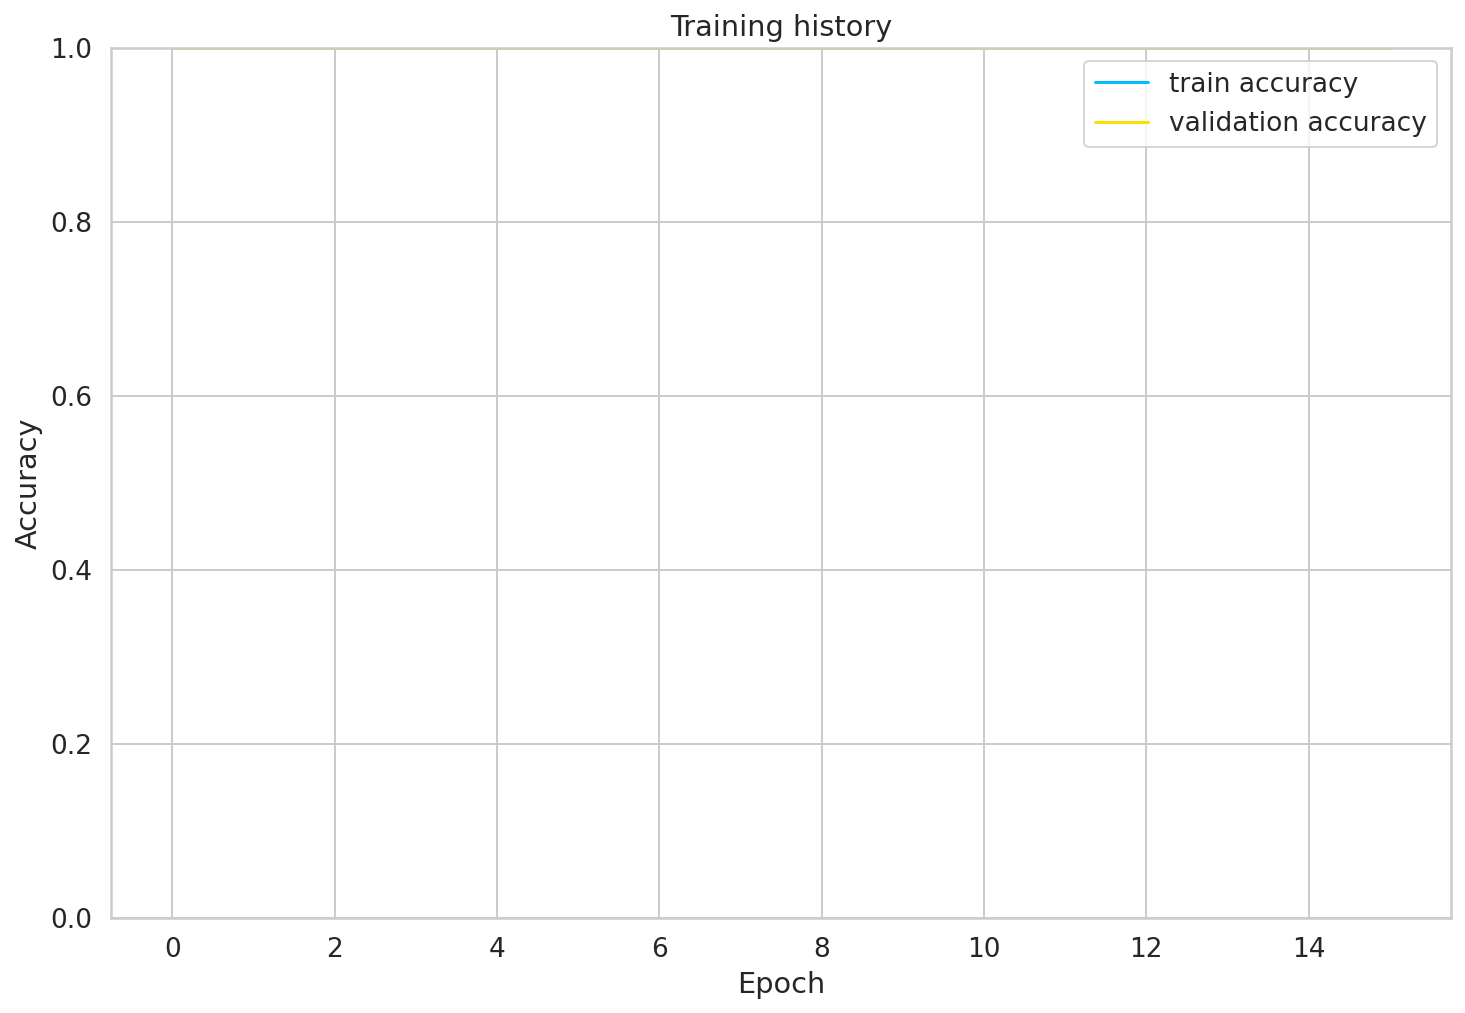

In [79]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [80]:
test_acc, _ = eval_model(model, test_data_loader, loss_fn, device, len(df_test))
test_acc.item()

/users/kent/jmaharja/.local/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/users/kent/jmaharja/.local/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to N

0.9957805907172995

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["tweet_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      token_type_ids = d["token_type_ids"].to(device)
      targets = d["targets"].to(device)

      outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
      _, preds = torch.max(outputs, dim=1)
      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [89]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model,train_data_loader)

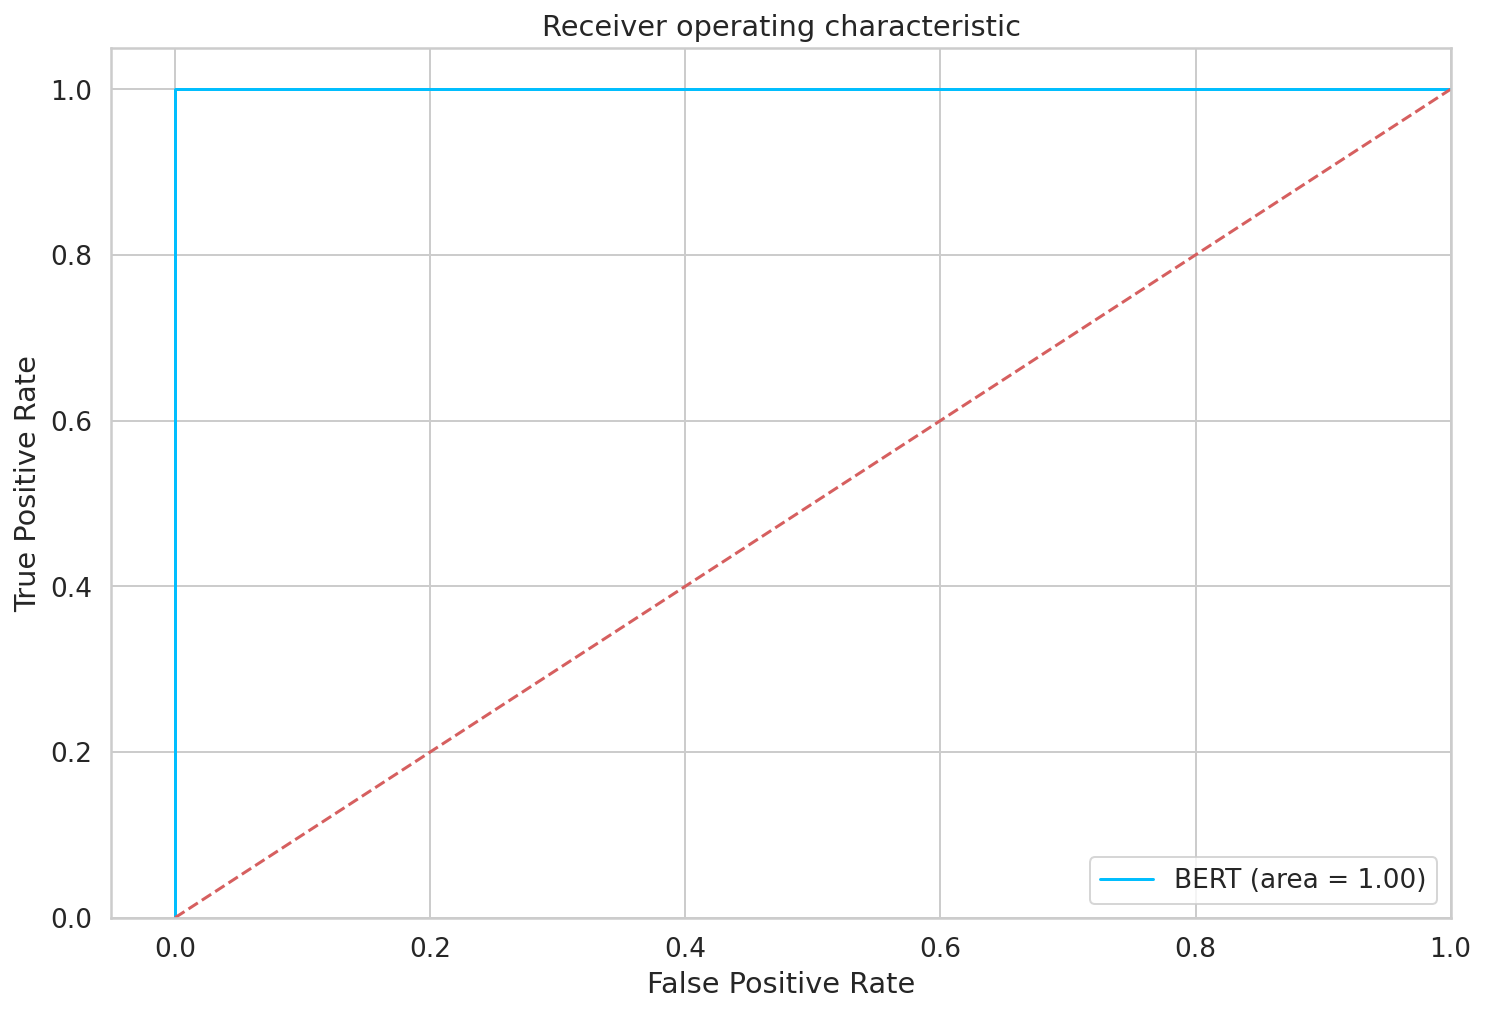

In [90]:
logit_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test.numpy(), y_pred_probs[:, 1].numpy())
plt.figure()
plt.plot(fpr, tpr, label='BERT (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images/Log_ROC_ '+'.png')
plt.show()

In [ ]:
y_pred_probs_pd = [y.numpy() for y in y_pred_probs]
someListOfLists = list(zip(y_review_texts, y_test.numpy(), y_pred.numpy(), y_pred_probs[:, 1:].numpy().squeeze(), y_pred_probs_pd ))
npa = np.asarray(someListOfLists)
dff = pd.DataFrame(someListOfLists, columns = ['readme', 'Real', 'Predicted', 'Pred-prob', 'All Pred-probs' ])
dff

In [ ]:
print(classification_report(y_test, y_pred, target_names=['Y', 'N']))

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=['Y', 'N'], columns=['Y', 'N'])
show_confusion_matrix(df_cm)